# FedEx Invoice Data Cleaning

In [1]:
import os
import glob
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 50)

In [2]:
# read in files 
extension = 'csv'
all_filenames = [i for i in glob.glob('FedEx_invoice*.{}'.format(extension))]

In [3]:
# reading in df fails since a column has commas
headers = [*pd.read_csv('FedEx_invoice.csv', nrows=1)]
headers_keep = ["Payor","Express or Ground Tracking ID","Net Charge Amount","Service Type","Shipment Date","POD Delivery Date",
"Actual Weight Amount","Rated Weight Amount","Dim Length","Dim Width","Dim Height","Dim Divisor","Recipient Name",
"Recipient Company","Recipient Address Line 1","Recipient Address Line 2","Recipient City","Recipient State","Recipient Zip Code",
"Shipper Company","Shipper Name","Shipper Address Line 1","Shipper Address Line 2","Shipper City","Shipper State",
"Shipper Zip Code","Original Customer Reference","Original Ref#2","Original Ref#3/PO Number","Zone Code"]

In [4]:
list_of_dfs = []
for file in all_filenames:
    df = pd.read_csv(file, usecols= headers_keep, low_memory=False)
    list_of_dfs.append(df)

df_master = pd.concat(list_of_dfs, ignore_index=True) 

In [5]:
# copy dataframe and start cleaning
df = df_master.copy()

# convert to integer 
#df[['POD Delivery Date', 'Recipient Zip Code', 'Original Ref#2', 'Original Ref#3/PO Number']] = df[['POD Delivery Date', 'Recipient Zip Code', 'Original Ref#2', 'Original Ref#3/PO Number']].astype('Int64')
  
# convert to datetime
from datetime import date
today = date.today()
d1 = int(today.strftime("%Y%m%d"))
df['POD Delivery Date'] = df['POD Delivery Date'].fillna(d1)
df['POD Delivery Date'] = pd.to_datetime(df['POD Delivery Date'], format='%Y%m%d')
df['Shipment Date'] = df['Shipment Date'].fillna(d1)
df['Shipment Date'] = pd.to_datetime(df['Shipment Date'], format='%Y%m%d')

# convert zip codes 
#df['Recipient Zip Code'] = df['Recipient Zip Code'].fillna('80231')
df['Shipper Zip Code'] = df['Shipper Zip Code'].fillna('80231')

#df['Recipient Zip Code'] = df['Recipient Zip Code'].astype(int).astype(str).str.zfill(5)
df['Shipper Zip Code'] = df['Shipper Zip Code'].astype(int).astype(str).str.zfill(5)

#df['Recipient Zip Code'] = df['Recipient Zip Code'].str[:5]
df['Shipper Zip Code'] = df['Shipper Zip Code'].str[:5]

In [6]:
# calculate true total charge -- adjustments are added as a second line with duplicate tracking numbers
df_tot_cost = pd.DataFrame()
df_tot_cost['Total Cost'] = df[['Express or Ground Tracking ID', 'Net Charge Amount']].groupby(by = 'Express or Ground Tracking ID').sum()
df_tot_cost.rename_axis("Express or Ground Tracking ID")

# append to DF as Total Cost
df = pd.merge(df,df_tot_cost['Total Cost'], 
                                    on ='Express or Ground Tracking ID', how='inner')

In [7]:
# change order numbers to remove strings from end. Only works for Shopify and DealCat

df['Original Customer Reference'] = np.where((df['Shipper Company'] == 'DealCat'),\
    df['Original Customer Reference'].str[:19],df['Original Customer Reference'].str[:7])

In [8]:
# Add Shipment Days 
df['Delivery Time'] = (df['POD Delivery Date']- df['Shipment Date']).dt.days

In [9]:
# Zone Code

df['Zone Code'] = df['Zone Code'].map({'04':'4.0', '06':'6.0','05':'5.0', '07':'7.0', '02':'2.0', '09':'9.0', '03':'3.0', '00':'0.0', '08':'8.0', 'A':'10.0',
       '53':'10.0', '7':'7.0'})

In [10]:
# to csv
df.to_csv('fedex_output.csv', header=True, index=False)

# Analysis 

In [11]:
df['Total Cost'].describe()

count    8210.000000
mean       18.156889
std        10.439490
min         6.710000
25%        13.850000
50%        16.240000
75%        19.975000
max       585.340000
Name: Total Cost, dtype: float64

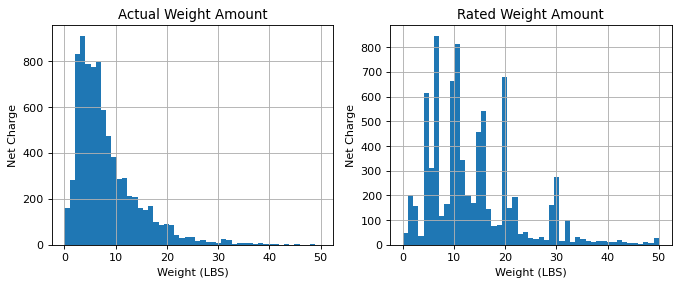

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80);

ax1 = plt.subplot(2, 2, 1)
HIST_BINS = np.linspace(0,50, 50)
ax1.set_title('Actual Weight Amount')
ax1.set_xlabel('Weight (LBS)')
ax1.set_ylabel('Net Charge')
ax1 = df['Actual Weight Amount'].hist(bins=HIST_BINS);

ax2 = plt.subplot(2, 2, 2)
HIST_BINS = np.linspace(0,50, 50)
ax2.set_title('Rated Weight Amount')
ax2.set_xlabel('Weight (LBS)')
ax2.set_ylabel('Net Charge')
ax2 = df['Rated Weight Amount'].hist(bins=HIST_BINS);

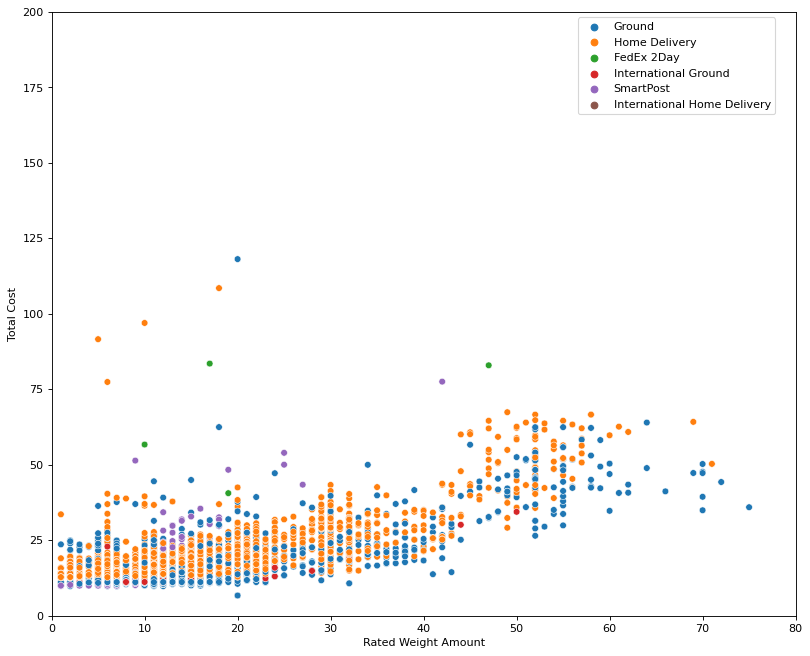

In [13]:
# Scatterplot grouped by shipping methods 

figure(figsize=(12, 10), dpi=80);

sns.scatterplot(x='Rated Weight Amount',
               y = 'Total Cost',
               hue = 'Service Type',
               data = df);

plt.xlim(0, 80)
plt.ylim(0, 200)

plt.legend(loc='best', bbox_to_anchor=(.7, 0., .6, 1));

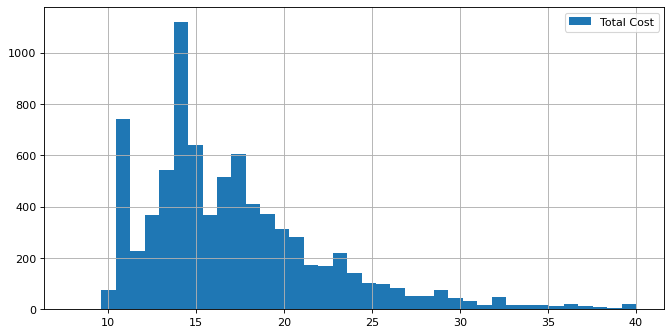

In [14]:
# Total Cost Histogram 

figure(figsize=(10, 5), dpi=80);
HIST_BINS = np.linspace(8,40, 40)
df['Total Cost'].hist(bins=HIST_BINS, legend=True);

In [15]:
# # Regression Plot by Shipping Service 

# g = sns.lmplot(x="Rated Weight Amount", y="Total Cost", hue="Service Type", data=df,

#                palette="Set1", height=10, legend='top right');

# plt.xlim(0, 70);
# plt.ylim(0, 75);

In [16]:
# # Total Outbound Delivery Time

# df_outbound = df.copy()
# df_outbound = df_outbound[df_outbound['Recipient Name'] != 'Pillows.com']
# fig, ax = plt.subplots()
# ax = sns.histplot(data=df_outbound, x="Delivery Time", hue="Zone Code", multiple="stack") 
# ax.set_xlim(1,10)
# plt.show()

In [17]:
# # Delivery Time by Zone 

# zones = ['2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0']
# for zone in zones:
#     df_hist = df_outbound[df_outbound['Zone Code'] == zone]
#     fig, ax = plt.subplots()
#     ax = sns.histplot(data=df_hist, x="Delivery Time")
#     ax.set_xlim(1,10)
#     plt.title("Time To Delivery Hist in Zone " + str(zone))
#     plt.show()

# Filtering (Date, Shipping Method, Outliers, etc)

In [18]:
# Filter by Date 
df_1 = df.copy()

# Year
df_1 = df_1[df_1['Shipment Date'].dt.strftime('%Y') == '2022']

# Month
df_1 = df_1[df_1['Shipment Date'].dt.strftime('%m') >= '07']

# outliers 
#df_1 = df_1[df_1['Total Cost'] <= 80]

# Service Type 
#df_1 = df_1[df_1['Service Type'] == 'SmartPost']
#df_1 = df_1[df_1['Service Type'] != 'FedEx 2Day']

# State
#df_1 = df_1[df_1['Recipient State'] == 'CA']

# Outbound 
df_1 = df_1[df_1['Recipient Name'] != 'Pillows.com']

# Zone Code 
#df_1 = df_1[df_1['Zone Code'] == '6.0']

# Rated Weight
#df_1 = df_1[df_1['Rated Weight Amount'] < 20]

# Drop Duplicates 
df_1 = df_1.drop_duplicates(subset=['Express or Ground Tracking ID'])

In [19]:
# Explore Data 
df_1['Total Cost'].describe()

count    733.000000
mean      18.233479
std       21.954063
min        9.970000
25%       13.550000
50%       16.090000
75%       19.320000
max      585.340000
Name: Total Cost, dtype: float64

In [20]:
# averages
mean_delivery = df_1['Delivery Time'].mean()
mean_total_cost = df_1['Total Cost'].mean()

print("Ave Delivery Time:", mean_delivery) 
print("Ave Total Cost:", mean_total_cost)

Ave Delivery Time: 3.3424283765347886
Ave Total Cost: 18.23347885402454


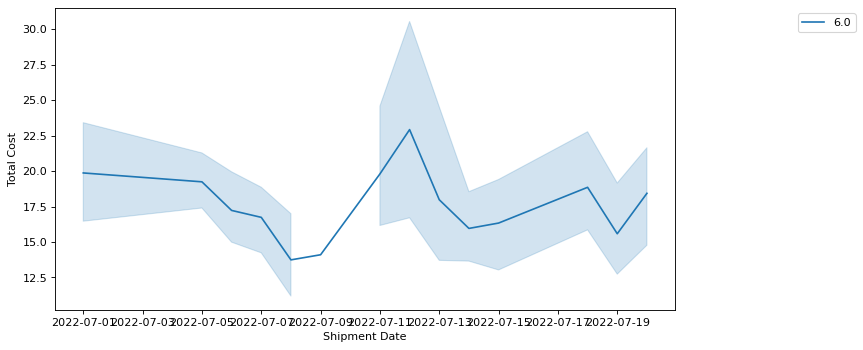

In [21]:
figure(figsize=(10, 5), dpi=80);

# Extra Filter
df_2 = df_1[df_1['Zone Code'] == '6.0']

sns.lineplot(data=df_2, x="Shipment Date", y="Total Cost", hue="Zone Code", style="Zone Code");
plt.legend(loc='best', bbox_to_anchor=(.7, 0., .6, 1));

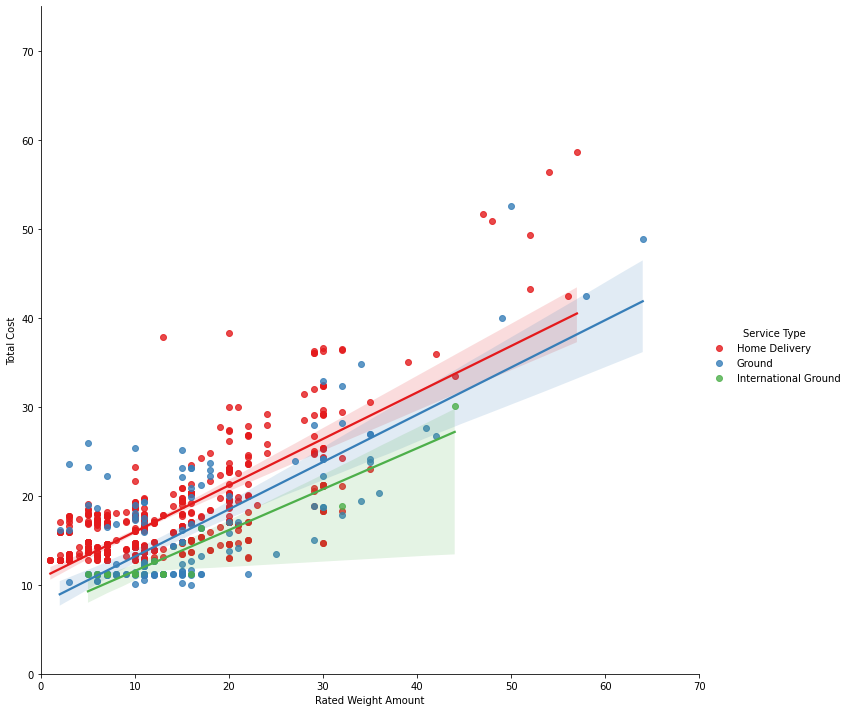

In [22]:
# Regression Plot by Shipping Service 

g = sns.lmplot(x="Rated Weight Amount", y="Total Cost", hue="Service Type", data=df_1,

               palette="Set1", height=10, legend='top right');

plt.xlim(0, 70);
plt.ylim(0, 75);

In [29]:
print("number of orders in this parametere:", df_1.shape[0])

number of orders in this parametere: 733


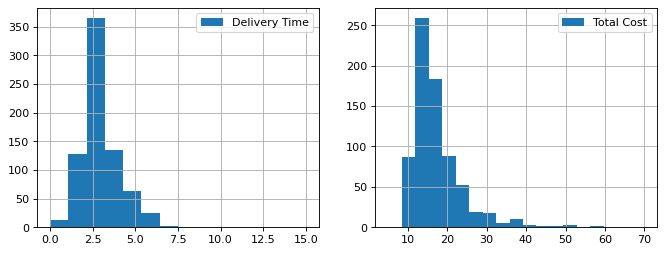

In [24]:
figure(figsize=(10, 8), dpi=80);

ax1 = plt.subplot(2, 2, 1)
HIST_BINS = np.linspace(0, 15, 15)
ax1 = df_1['Delivery Time'].hist(bins=HIST_BINS, legend=True);

ax2 = plt.subplot(2, 2, 2)
HIST_BINS = np.linspace(5, 70, 20)
ax2 = df_1['Total Cost'].hist(bins=HIST_BINS, legend=True);

In [25]:
# figure(figsize=(40, 20), dpi=80);
# ax = sns.boxplot(x="Rated Weight Amount", y="Total Cost", data=df_1)